## 0. Packages intallation

In [ ]:
!pip install langdetect
!pip install transformers
!pip install sentence-transformers
!pip install ktrain
!pip install scikit-plot
!pip install pytorch-pretrained-bert pytorch-nlp

In [2]:
# Connection with Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Definition of the project base folder
dir_base = "/content/drive/My Drive/Sorcero_Test"
dir_dataset = dir_base + "/data/"

In [4]:
# Importing useful libraries
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
%time
import time
import random
import pandas as pd
import numpy as np
import os
import re
import shutil
import sys
import string
import regex
from tqdm.notebook import tqdm
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from langdetect import detect, DetectorFactory
from transformers import TFBertModel, create_optimizer, BertTokenizer, BertModel
from nltk.tokenize import RegexpTokenizer
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from ktrain import text
import scikitplot as skplt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Found GPU at: /device:GPU:0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

## 1. Exploring the dataset

In [6]:
# Importing dataset

df_dev = pd.read_csv(dir_dataset + "/dev.tsv",sep= "\t", index_col=0)
df_train = pd.read_csv(dir_dataset + "/train.tsv",sep= "\t", index_col=0)
df_test = pd.read_csv(dir_dataset + "/test.tsv", sep= "\t", index_col=0)

df_dataset = pd.concat([df_dev, df_train, df_test]) # Concatenating datasets for easy preprocessing

In [7]:
# Exploring dataset
df_dataset.head()

,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,claim_id
34656,A baby died at an unnamed medical facility be...,"November 10, 2015",Fellow Twitter users suggested @FierceFemtivis...,Kim LaCapria,"On 8 November 2015, former Twitter user @Fierc...",http://webcache.googleusercontent.com/search?q...,unproven,"Politics, fiercefemtivist, racism",NaN
3632,Bat from Shawnee County tests positive for rab...,NaN,A bat found in northeastern Kansas has tested ...,,Topeka television station KSNT reports that th...,https://www.ksnt.com/news/bat-tests-positive-f...,true,"Rabies, Health, General News, Kansas, Bats, To...",NaN
29558,Germany has banned pork from school canteens b...,"March 7, 2016",What's true: Some politicians complained that ...,Kim LaCapria,"On 7 March 2016, British tabloid Express repor...",http://bnp.org.uk/news/regional/bnp-victory-br...,false,Politics,NaN
8416,Coronavirus prompts Canada to roll out safe dr...,"April 16, 2020",Canada’s Pacific province of British Columbia ...,Tessa Vikander,"In March, the Canadian government urged provin...",,true,Health News,NaN
7169,"Wayne National Forest plans fires for tree, wi...",NaN,"Nearly 2,000 acres of Wayne National Forest in...",,Forest officials say scientists who study nati...,,true,"Plants, Wildlife, Health, Wildlife health, For...",NaN


In [8]:
df_dataset["label"].unique() # Noise is detected in the label column (labels different from the expected 4 described in https://huggingface.co/datasets/health_fact)

array(['unproven', 'true', 'false', 'mixture', nan,
       'National, Candidate Biography, Donald Trump, ', 'snopes'],
      dtype=object)

## 2. Cleaning the dataset

In [9]:
# Dropping noise rows (label different from the expected 4)

df_dataset = df_dataset.loc[(df_dataset['label'] == 'unproven') | (df_dataset['label'] == 'true') | (df_dataset['label'] == 'false') | (df_dataset['label'] == 'mixture')]

In [10]:
display(df_dataset.groupby(by='label').size()) 

label
false       3769
mixture     1799
true        6306
unproven     377
dtype: int64

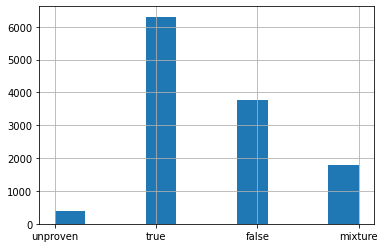

In [11]:
df_dataset['label'].hist()

In [12]:
df_dataset.isna().sum() # Checking that claim column does not have nan values

claim                 0
date_published     2398
explanation           0
fact_checkers         0
main_text             0
sources               1
label                 0
subjects              0
claim_id          11018
dtype: int64

In [13]:
df_dataset.shape

(12251, 9)

In [14]:
# Converting label column to numerical
#### true - 0
#### false - 1
#### mixture - 2
#### unproven - 3
#df_dataset['label_desc'] = df_dataset['label'] 
df_dataset['label'].replace(to_replace=['true', 'false', 'mixture', 'unproven'], value=[0, 1, 2, 3], inplace=True)

In [15]:
# Language review to ensure that the claims are written in English ############
df_dataset['Language'] = df_dataset['claim'].apply(detect)

In [16]:
display(df_dataset.groupby(by='Language').size()) # Claims in other languages different to English (English is the expected language according to https://huggingface.co/datasets/health_fact))

Language
af       18
ca       20
cy        1
da       16
de       25
en    12091
es        5
et        2
fr       23
hr        1
id        2
it       13
lt        1
nl       14
no        4
ro        6
sv        1
tl        6
tr        1
vi        1
dtype: int64

In [17]:
idx_drop = df_dataset[(df_dataset['Language'] != "en")].index # Removing all claims in other language
df_dataset.drop(idx_drop, inplace = True)

In [18]:
df_dataset.shape

(12091, 10)

In [19]:
df_dataset.columns

Index(['claim', 'date_published', 'explanation', 'fact_checkers', 'main_text',
       'sources', 'label', 'subjects', 'claim_id', 'Language'],
      dtype='object')

In [20]:
# Keeping important columns
df_dataset = df_dataset.loc[:, ['claim', 'label']]

In [21]:
df_dataset.head()

,claim,label
34656,A baby died at an unnamed medical facility be...,3
3632,Bat from Shawnee County tests positive for rab...,0
29558,Germany has banned pork from school canteens b...,1
8416,Coronavirus prompts Canada to roll out safe dr...,0
7169,"Wayne National Forest plans fires for tree, wi...",0


In [22]:
# Saving the cleaned dataset from dataframe to csv

df_dataset.to_csv(dir_dataset + "claims_dataset_cleaned.csv")

## _______________________________________________________________________________

*Points 1 and 2 can be skipped and jumping directly from 0 to 3. Connecting with cleaned dataset*






## 3. Connecting with the cleaned dataset

In [23]:
# Reading csv dataset cleaned in steps 1 and 2

df_dataset = pd.read_csv(dir_dataset + "claims_dataset_cleaned.csv", index_col=0)

In [24]:
display(df_dataset)

,claim,label
34656,A baby died at an unnamed medical facility be...,3
3632,Bat from Shawnee County tests positive for rab...,0
29558,Germany has banned pork from school canteens b...,1
8416,Coronavirus prompts Canada to roll out safe dr...,0
7169,"Wayne National Forest plans fires for tree, wi...",0
...,...,...
1230,Christmas miracle for Florida dog whose heart ...,0
1231,Another dolphin dies at Arizona aquatic facility.,0
1232,"What the facts say"" is ... ""the best scenario ...",1
1233,FDA advisory panel rejects J&J drug for acute ...,0


In [25]:
# Once we have preprocessed the dataset, we split it again in train and test subsets
from sklearn.model_selection import train_test_split

X = df_dataset.claim.values
y = df_dataset.label.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7) # Split between train and validation
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=7) #Split between train and test

## 4. Text preprocessing

### Claim standarization

In order to process and classify claims, we need to bring the text into a form that is predictable and analyzable. To do so, we apply the function *claim_processing*.

In [26]:
nltk.download('stopwords')

def claim_preprocessing(claim):
    # Lowercasing the sentence
    claim = claim.lower() 
    # Changing 't to 'not'
    claim = re.sub(r"\'t", " not", claim) 
    # Removing @name
    claim = re.sub(r'(@.*?)[\s]', ' ', claim)
    # Removing punctuations except '?'
    claim = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', claim)
    claim = re.sub(r'[^\w\s\?]', ' ', claim)
    # Removing some special characters
    claim = re.sub(r'([\;\:\|•«\n])', ' ', claim)
    # Removing stopwords except 'not' and 'can'
    claim = " ".join([word for word in claim.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    claim = re.sub(r'\s+', ' ', claim).strip()
    
    return claim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Tokenizing

In order to use a pre-trained BERT model, the input data needs to be converted into an appropriate format in order that each sentence can be sent to the pre-trained model to obtain the corresponding embedding. 
The tokenizer object allows the conversion from character strings to tokens understood by the different models.

In order to tokenize any sentece, next steps need to be followed: 

*   **Step 1:** Add the [CLS] and [SEP] tokens: [CLS] token at the beginning, and the [SEP] token at the end of each input text.
*   **Step 2:** Pad or truncate the sentence to the maximum length allowed: for sentences that are shorter than this maximum length, we will have to add paddings (empty tokens) to the sentences to make up the length.
*   **Step 3**: Create the attention masks which explicitly differentiate real tokens from [PAD] tokens

*Extracted from Huggingface transformers documentation: https://huggingface.co/transformers/model_doc/bert.html*

In [27]:
from transformers import BertTokenizer

# Loading the BERT tokenizer. Each model has its own tokenizer, and some tokenizing methods are different across tokenizers
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

# Creating a function to tokenize claims
def preprocessing_claim_for_bert(data):
    input_ids = []      # Empty lists to store outputs
    attention_masks = []

    for claim in data:
        encoded_claim = tokenizer.encode_plus(  # Encode the tokens into their corresponding IDs 
            text = claim_preprocessing(claim),  # Step 0: Preprocessing claim
            add_special_tokens=True,        # Step 1: Adding '[CLS]' and '[SEP]'
            max_length = MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length = True,         # Step 2: Pad sentence to max length
            return_attention_mask=True       # Step 3: Return attention mask
            )
        
        # Adding the outputs to the lists
        input_ids.append(encoded_claim.get('input_ids'))
        attention_masks.append(encoded_claim.get('attention_mask'))

    # Converting lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks # Returning inputs_ids and attention_masks as tensors

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
# Concatenating claims 
all_claims = np.concatenate([df_dataset['claim'].values])

# Encode our concatenated data
encoded_claims = [tokenizer.encode(claim, add_special_tokens=True) for claim in all_claims]

# Finding the maximum length
max_len = max([len(claim) for claim in encoded_claims])
print('Max length: ', max_len)

#Specify 'MAX_LEN'
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_claim_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function 'preprocessing_claim_for_bert' on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_claim_for_bert(X_train)
val_inputs, val_masks = preprocessing_claim_for_bert(X_val)

Max length:  104
Original:   A baby died at an unnamed medical facility because its parents refused to allow a black nurse to care for the child.
Token IDs:  [101, 3336, 2351, 13294, 2966, 4322, 3008, 4188, 3499, 2304, 6821, 2729, 2775, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Converting other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# In order to fine-tune BERT, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=8)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 5. Building and training the model - TL from BERT Transformer

In order to complete the proposed task, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. 

Fine-tunning this modeling has several advantages comparing it to training a specific deep learning model (a CNN, BiLSTM, etc.). Among others:
- Less training time: the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task 
- Less data
- Good results

In [30]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top
# "uncased" because it has only lowercase letters and "base" because it is the smaller version of the two BERT pretrained models

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5) 
model.cuda()


100%|██████████| 407873900/407873900 [00:30<00:00, 13474362.61B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

As displayed before, we can see that each encoder layer has a BertEmbedding layer at the beginning, followed by a Transformer architecture (BertAttention, BertIntermediate, BertOutput). At the end of the 12 encoders, we have the Classifier layer.

Once we have loaded the pre-trained BERT model, we grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

References: https://developer.nvidia.com/blog/efficient-bert-finding-your-optimal-model-with-multimetric-bayesian-optimization-part-2/

In [31]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [32]:
# Optimizer variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [33]:
# Calculating the accuracy of our predictions vs labels
def get_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Rarding the training of our model, we divide it in two phases:

**Training loop:**

- Setting the emodel in training mode (computing gradients)
- Unpacking input data (inputs and labels)
- Loading data into the GPU for acceleration
- Clearing out the gradients calculated in the previous pass (in pytorch the gradients are accumulating by default)
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Update parameters with optimizer.step()
- Track variables for monitoring progress

**Validation loop**:

- Setting the emodel in evaluation mode (not computing gradients)
- Unpacking input data (inputs and labels)
- Loading data into the GPU for acceleration
- Forward pass (feed input data through the network)
- Computing loss on our validation data
- Track variables for monitoring progress

In [34]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training Loop
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation Loop

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = get_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 1.0257126488851214


Epoch:  25%|██▌       | 1/4 [08:12<24:36, 492.27s/it]

Validation Accuracy: 0.6023632271468145
Train loss: 0.8968082181739702


Epoch:  50%|█████     | 2/4 [16:22<16:21, 490.92s/it]

Validation Accuracy: 0.6336132271468145
Train loss: 0.8439254175251414


Epoch:  75%|███████▌  | 3/4 [24:32<08:10, 490.74s/it]

Validation Accuracy: 0.6270342797783934
Train loss: 0.8027004900633828


Epoch: 100%|██████████| 4/4 [32:43<00:00, 490.97s/it]

Validation Accuracy: 0.6340244113573408


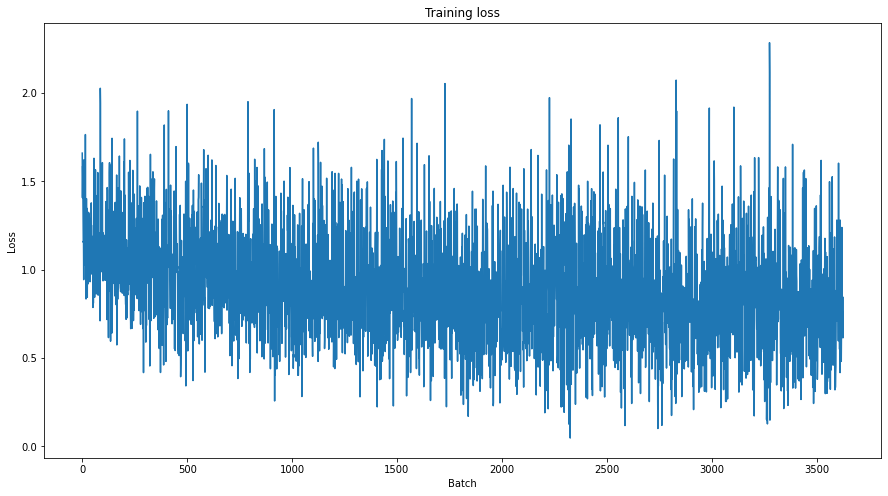

In [35]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## 6. Performance evaluation

### Setup test dataset for BERT


In [36]:
# Running 'preprocessing_claim_for_bert' on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_claim_for_bert(X_test)

test_labels = torch.tensor(y_test)

# Creating the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### Compute predicted probabilities on the test set

In [37]:
def seq_bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during the test time.
    model.eval()
    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs # Output tensor with shape (batch_size, num_labels)

In [38]:
# Compute predicted probabilities on the test set
probs = seq_bert_predict(model, test_dataloader)
y_pred = np.argmax(probs, axis=1, out=None)

### Performance metrics

In [39]:
def evaluate_classifier(y_pred, y_true):
    preds = probs[:, 1]
       
    # Get accuracy over the test set
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # Plot a multilabel confusion matrix
    fig = plt.figure()
    skplt.metrics.plot_confusion_matrix(y_true, y_pred, figsize=(12,15))
    fig.suptitle('Confusion Matrix', fontsize=16)

    # Get Classification Report
    print(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)))

Accuracy: 30.27%
                0           1      2     3  accuracy    macro avg  weighted avg
precision     0.0    0.302730    0.0   0.0   0.30273     0.075682      0.091645
recall        0.0    1.000000    0.0   0.0   0.30273     0.250000      0.302730
f1-score      0.0    0.464762    0.0   0.0   0.30273     0.116190      0.140697
support    1229.0  732.000000  372.0  85.0   0.30273  2418.000000   2418.000000


<Figure size 432x288 with 0 Axes>

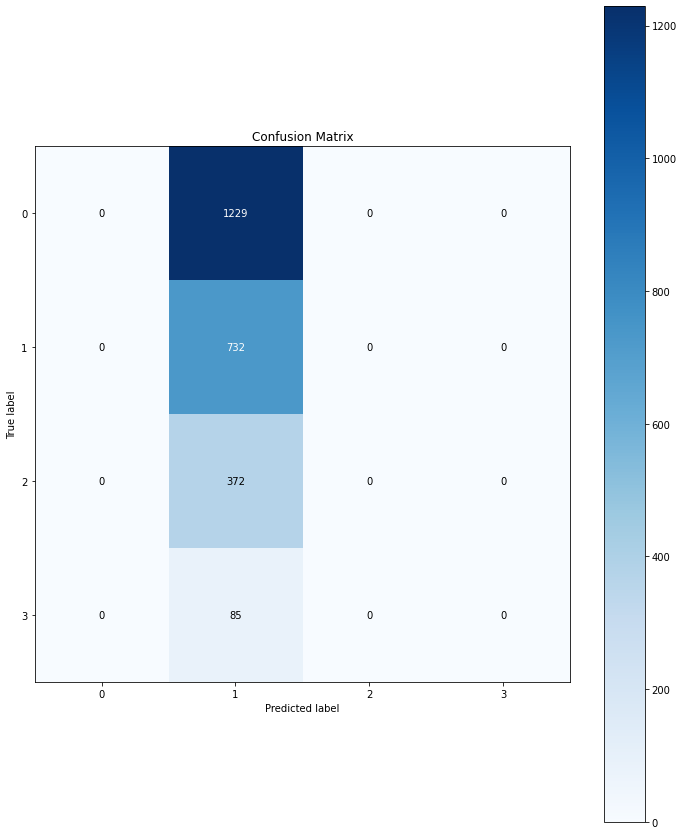

In [40]:
# Evaluate the Bert classifier
evaluate_classifier(y_pred, test_labels)

When we use the trained model to predict the veracity on the unseen test dataset, the confusion matrix clearly shows how the model overfits to the majority True classes.

Model performance can be increased with using additional techniques as Data Augmentation given that the input dataset is clearly bias including as the vast majority claims categorized as True and False.

## Trying out the model with a new health claim

Once we have a final model, we apply it to a different health claim from a different source: 

**External claim:** *Receiving many vaccines for different diseases at the same time increases the risk of undesirable effects and can overload the immune system*

**True label:** False

Rationale found in http://proyectoavatar.enfermeriacomunitaria.org/vacunas/mitos-y-realidades (13rd Myth)

In [44]:
external_claim = "Receiving many vaccines for different diseases at the same time increases the risk of undesirable effects and can overload the immune system"

In [45]:
# Running 'preprocessing_claim_for_bert' on the external claim
print('Tokenizing data...')
b_input_ids, b_attn_mask = preprocessing_claim_for_bert(external_claim)

print('Applying BERT tokenizer prediction..')
with torch.no_grad():
    logits = model(b_input_ids.to(device), b_attn_mask.to(device))
    probs = F.softmax(logits, dim=1).cpu().numpy()
    y_pred = np.unique(np.argmax(probs, axis=1, out=None))

Tokenizing data...
Applying BERT tokenizer prediction..


In [46]:
def veracity_prediction(y_pred):
  if str(y_pred[0]) == '1':
    return 'True'
  if str(y_pred[0]) == '2':
    return 'False'
  if str(y_pred[0]) == '3':
    return 'Mixture'
  if str(y_pred[0]) == '4':
    return 'Unproven'

print('Veracity prediction: ' + veracity_prediction(y_pred))

Veracity prediction: True
